
--- ЗАВДАННЯ 1: Дослідження структури часового ряду (Кількість візитів) ---


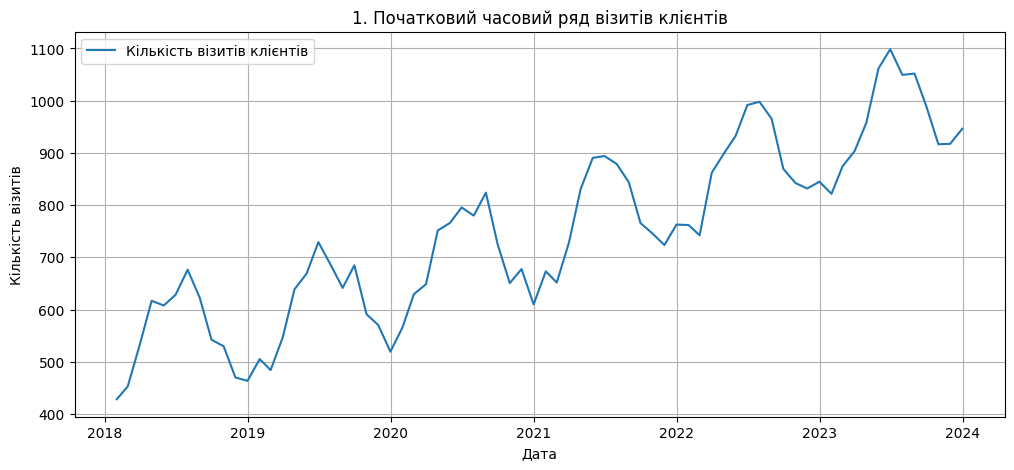

-> А. Декомпозиція ряду:


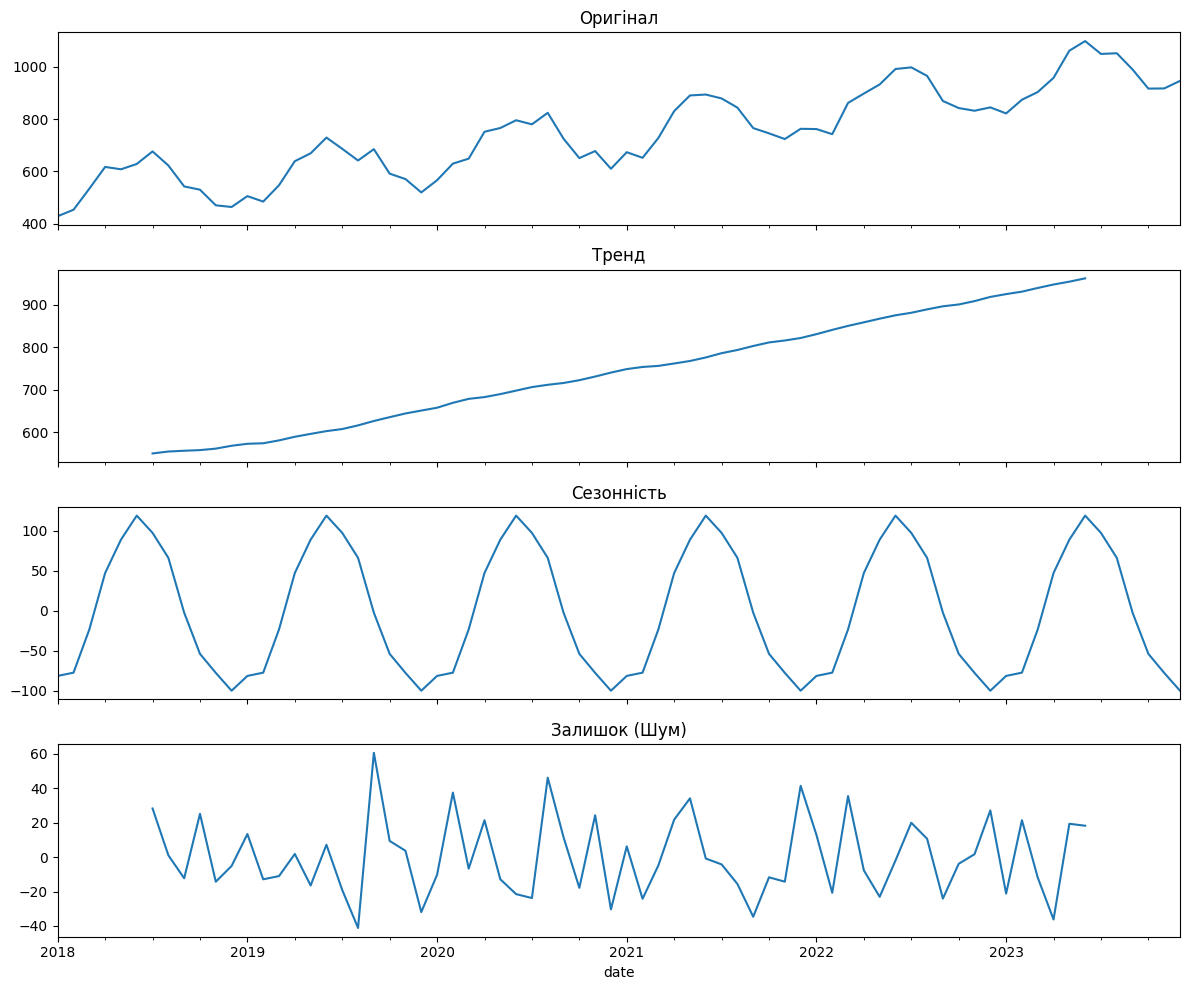


-> Б. Перевірка стаціонарності (Тест Дікі-Фуллера):
ADF статистика = 1.6089
p-value = 0.9979
Ряд нестаціонарний (p-value > 0.05). Потрібне диференціювання.
Рекомендовано диференціювати (d=1) для стаціонарності.

--- ЗАВДАННЯ 2: Побудова математичної моделі (SARIMA) ---
Модель SARIMA успішно побудована: AIC=1142.45

-> Статистичний звіт моделі (для аналізу параметрів):
                                      SARIMAX Results                                       
Dep. Variable:                               visits   No. Observations:                   60
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -566.224
Date:                              Wed, 22 Oct 2025   AIC                           1142.448
Time:                                      13:04:48   BIC                           1149.777
Sample:                                  01-31-2018   HQIC                          1144.877
                                       - 12-31-2022                   

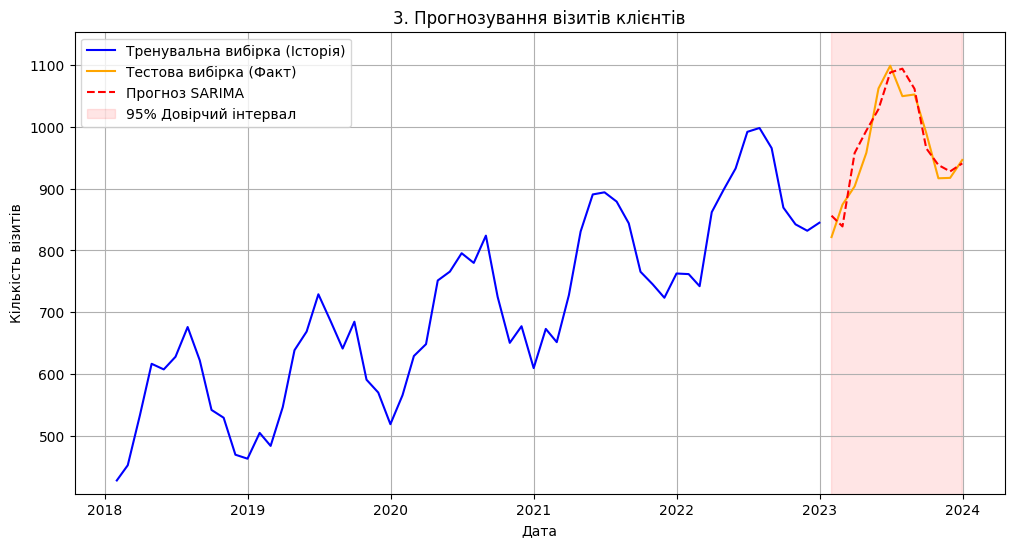


--- ЗАВДАННЯ 4: Кореляційний аналіз між двома процесами ---


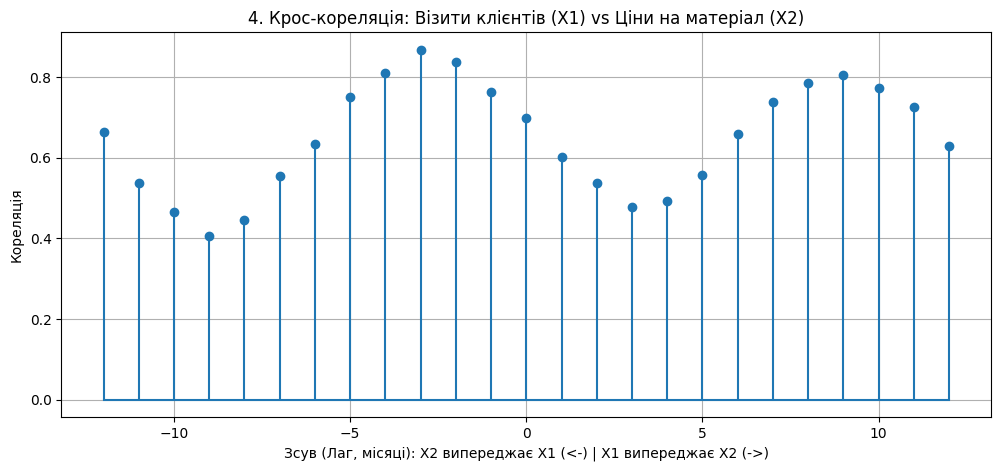

Найсильніша абсолютна взаємна кореляція при лагу = -3
   Інтерпретація: X2 (Ціни) впливає на X1 (Візити) з затримкою 3 місяців.

--- ЗАВДАННЯ 5: Згладжування та фільтрація ---


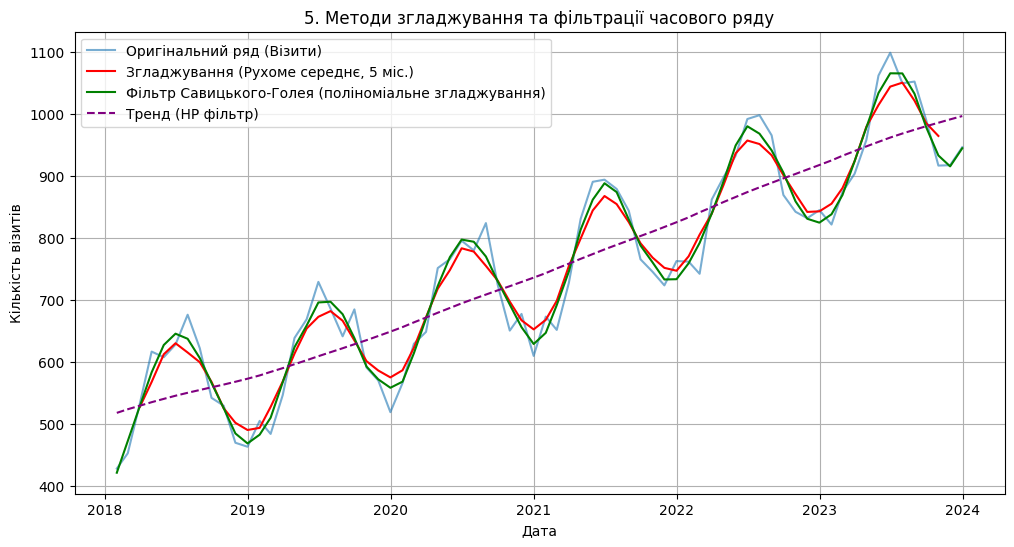

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import ccf
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter
import warnings
import statsmodels.api as sm


warnings.filterwarnings("ignore")


np.random.seed(42)
date_rng = pd.date_range(start='2018-01-01', end='2023-12-31', freq='M')


trend = np.linspace(500, 1000, len(date_rng))


month_index = date_rng.month
seasonality = 100 * np.sin(2 * np.pi * (month_index - 3) / 12)


noise = np.random.normal(0, 30, len(date_rng))


customer_visits = trend + seasonality + noise
data = pd.DataFrame({'date': date_rng, 'visits': customer_visits}).set_index('date')




# --- ЗАВДАННЯ 1: Дослідження структури часового ряду ---


print("\n--- ЗАВДАННЯ 1: Дослідження структури часового ряду (Кількість візитів) ---")


plt.figure(figsize=(12, 5))
plt.plot(data['visits'], label='Кількість візитів клієнтів')
plt.title('1. Початковий часовий ряд візитів клієнтів')
plt.xlabel('Дата'); plt.ylabel('Кількість візитів')
plt.legend(); plt.grid(True)
plt.show()


print("-> А. Декомпозиція ряду:")
decomposition = sm.tsa.seasonal_decompose(data['visits'], model='additive', period=12)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
decomposition.observed.plot(ax=ax1, title='Оригінал')
decomposition.trend.plot(ax=ax2, title='Тренд')
decomposition.seasonal.plot(ax=ax3, title='Сезонність')
decomposition.resid.plot(ax=ax4, title='Залишок (Шум)')
plt.tight_layout()
plt.show()




print("\n-> Б. Перевірка стаціонарності (Тест Дікі-Фуллера):")
result = adfuller(data['visits'])
print(f"ADF статистика = {result[0]:.4f}")
print(f"p-value = {result[1]:.4f}")


if result[1] > 0.05:
    print("Ряд нестаціонарний (p-value > 0.05). Потрібне диференціювання.")
    d_value = 1
    print("Рекомендовано диференціювати (d=1) для стаціонарності.")
else:
    print("Ряд стаціонарний (p-value <= 0.05).")
    d_value = 0




# --- ЗАВДАННЯ 2: Побудова математичної моделі SARIMA ---


print("\n--- ЗАВДАННЯ 2: Побудова математичної моделі (SARIMA) ---")


train = data.iloc[:-12]
test = data.iloc[-12:]


model = SARIMAX(train['visits'],
                order=(1, d_value, 2),
                seasonal_order=(0, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)


res = model.fit(disp=False)
print(f"Модель SARIMA успішно побудована: AIC={res.aic:.2f}")


print("\n-> Статистичний звіт моделі (для аналізу параметрів):")
print(res.summary().as_text())




# --- ЗАВДАННЯ 3: Прогнозування майбутнього розвитку ---


print("\n--- ЗАВДАННЯ 3: Прогнозування майбутнього розвитку економічного процесу ---")


forecast = res.get_forecast(steps=12)
pred = forecast.predicted_mean
conf_int = forecast.conf_int()


rmse = np.sqrt(mean_squared_error(test['visits'], pred))
print(f"RMSE (Середньоквадратична похибка) на тестовій вибірці (12 місяців): {rmse:.3f}")


plt.figure(figsize=(12, 6))
plt.plot(train.index, train['visits'], label='Тренувальна вибірка (Історія)', color='blue')
plt.plot(test.index, test['visits'], label='Тестова вибірка (Факт)', color='orange')
plt.plot(test.index, pred, label='Прогноз SARIMA', color='red', linestyle='--')


plt.fill_between(test.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='red', alpha=0.1, label='95% Довірчий інтервал')


y_min = data['visits'].min() * 0.95
y_max = data['visits'].max() * 1.05


plt.ylim(y_min, y_max)
# --------------------------------------------------------------------------


plt.title('3. Прогнозування візитів клієнтів')
plt.xlabel('Дата'); plt.ylabel('Кількість візитів')
plt.legend(); plt.grid(True)
plt.show()




# --- ЗАВДАННЯ 4: Дослідження причинно-наслідкових зв’язків ---


print("\n--- ЗАВДАННЯ 4: Кореляційний аналіз між двома процесами ---")


customer_visits = data['visits'].copy()
raw_material_price = customer_visits.shift(3) * 0.5 + np.random.normal(0, 50, len(customer_visits))
raw_material_price = raw_material_price.fillna(method='bfill')
data['raw_material_price'] = raw_material_price


x1 = data['visits']
x2 = data['raw_material_price']


lags = np.arange(-12, 13)
cross_corr = [np.corrcoef(x1[max(0, lag):len(x1)+min(0, lag)],
                          x2[max(0, -lag):len(x2)+min(0, -lag)])[0,1] for lag in lags]


plt.figure(figsize=(12, 5))
plt.stem(lags, cross_corr, basefmt="C0-")
plt.title('4. Крос-кореляція: Візити клієнтів (X1) vs Ціни на матеріал (X2)')
plt.xlabel('Зсув (Лаг, місяці): X2 випереджає X1 (<-) | X1 випереджає X2 (->)')
plt.ylabel('Кореляція')
plt.grid(True)
plt.show()


max_corr_lag = lags[np.argmax(np.abs(cross_corr))]
print(f"Найсильніша абсолютна взаємна кореляція при лагу = {max_corr_lag}")
if max_corr_lag > 0:
    print(f"   Інтерпретація: X1 (Візити) впливає на X2 (Ціни) з затримкою {max_corr_lag} місяців.")
elif max_corr_lag < 0:
    print(f"   Інтерпретація: X2 (Ціни) впливає на X1 (Візити) з затримкою {abs(max_corr_lag)} місяців.")
else:
    print("   Інтерпретація: Максимальна кореляція без затримки.")




# --- ЗАВДАННЯ 5: Перетворення ряду (згладжування, фільтрація) ---


print("\n--- ЗАВДАННЯ 5: Згладжування та фільтрація ---")


data['moving_avg'] = data['visits'].rolling(window=5, center=True).mean()


data['savgol'] = savgol_filter(data['visits'], window_length=9, polyorder=3)


cycle_hp, trend_hp = hpfilter(data['visits'], lamb=1600)
data['trend_hp'] = trend_hp




plt.figure(figsize=(12, 6))
plt.plot(data['visits'], label='Оригінальний ряд (Візити)', alpha=0.6)
plt.plot(data['moving_avg'], label='Згладжування (Рухоме середнє, 5 міс.)', color='red')
plt.plot(data['savgol'], label='Фільтр Савицького-Голея (поліноміальне згладжування)', color='green')
plt.plot(data['trend_hp'], label='Тренд (HP фільтр)', color='purple', linestyle='--')
plt.title('5. Методи згладжування та фільтрації часового ряду')
plt.xlabel('Дата'); plt.ylabel('Кількість візитів')
plt.legend(); plt.grid(True)
plt.show()